# Stock Forecasting with GARCH Model

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model
#import pandas_datareader.data as web
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

## S&P 500

In [4]:
spy = pd.read_csv('datasets/spy.csv') 

In [5]:
spy.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-31,147.50000,146.250000,146.84375,146.8750,3172700.0,97.812355
2000-01-03,148.25000,143.875000,148.25000,145.4375,8164300.0,96.854988
2000-01-04,144.06250,139.640625,143.53125,139.7500,8089800.0,93.067429
2000-01-05,141.53125,137.250000,139.93750,140.0000,12177900.0,93.233864
2000-01-06,141.50000,137.750000,139.62500,137.7500,6227200.0,91.735512


In [6]:
spy.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-04,313.000000,309.079987,311.109985,311.359985,75794400.0,303.404938
2020-06-05,321.269989,317.160004,317.230011,319.339996,150524700.0,311.181122
2020-06-08,323.410004,319.630005,320.220001,323.200012,73641200.0,314.942535
2020-06-09,323.279999,319.359985,320.299988,320.790009,77479200.0,312.594086
2020-06-10,322.390015,318.220001,321.420013,319.000000,95000800.0,310.849823


In [7]:
df = spy[["Close"]]
df.head()

,Close
Date,
1999-12-31,146.8750
2000-01-03,145.4375
2000-01-04,139.7500
2000-01-05,140.0000
2000-01-06,137.7500


In [8]:
df["Pct"] = df.Close.pct_change(1)*100
df.head()

,Close,Pct
Date,,
1999-12-31,146.8750,NaN
2000-01-03,145.4375,-0.978723
2000-01-04,139.7500,-3.910615
2000-01-05,140.0000,0.178891
2000-01-06,137.7500,-1.607143


In [9]:
# Splitting as train and test data.
train = df.loc[:"2018-01-01"]
test = df.loc["2018-01-01" : ]

Text(0.5, 1.0, 'SPY Returns')

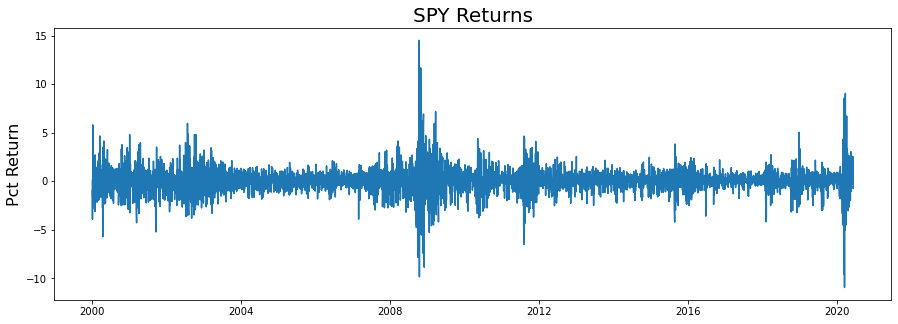

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df["Pct"])
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Returns', fontsize=20)

### Stationary Test

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def adfuller_test(ts):
    adfuller_result = adfuller(ts,autolag=None)
    adfuller_out=pd.Series(adfuller_result[0:4],index=['Test Statistic','p-value','Lags Used','Number of observations Used'])
    print(adfuller_out)
adfuller_test(df.Pct[1:])

Test Statistic                -1.358482e+01
p-value                        2.090191e-25
Lags Used                      3.300000e+01
Number of observations Used    5.108000e+03
dtype: float64


### p value is less than 0.05, so we can say data is stationary

## PACF

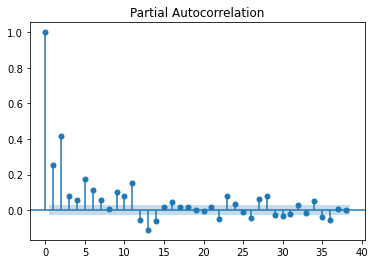

In [13]:
plot_pacf(df.Pct[1:]**2)
plt.show()

PACF is more significant till 2 so we will proceed with GARCH(2,2) model

## GARCH(2,2)

In [14]:
# GARCH with previous 2 residual and variance
model_garch = arch_model(df.Pct[1:], mean = "Constant", vol = "Garch", p=2, q=2)
results_garch = model_garch.fit(update_freq=5)
results_garch.summary()

Iteration:      5,   Func. Count:     49,   Neg. LLF: 2106766157.4072833
Iteration:     10,   Func. Count:     89,   Neg. LLF: 7055.683636882406
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7055.683621971442
            Iterations: 12
            Function evaluations: 102
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    Pct   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7055.68
Distribution:                  Normal   AIC:                           14123.4
Method:            Maximum Likelihood   BIC:                           14162.6
                                        No. Observations:                 5142
Date:                Fri, Jan 28 2022   Df Residuals:                     5141
Time:                        22:43:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0663  1.096e-02      6.051  1.437e-09 [4.484e-02,8.780e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0403  9.924e-03      4.063  4.838e-05 [2.087e-02,5.978e-02]
alpha[1]       0.0805  2.192e-02      3.672  2.403e-04   [3.754e-02,  0.123]
alpha[2]       0.1319  3.102e-02      4.253  2.107e-05   [7.113e-02,  0.193]
beta[1]        0.3103      0.296      1.047      0.295     [ -0.271,  0.891]
beta[2]        0.4483      0.261      1.718  8.573e-02  [-6.304e-02,  0.960]
============================================================================

Covariance estimator: robust
"""

beta[2] value is significant,so we will go with GARCH(2,2) model

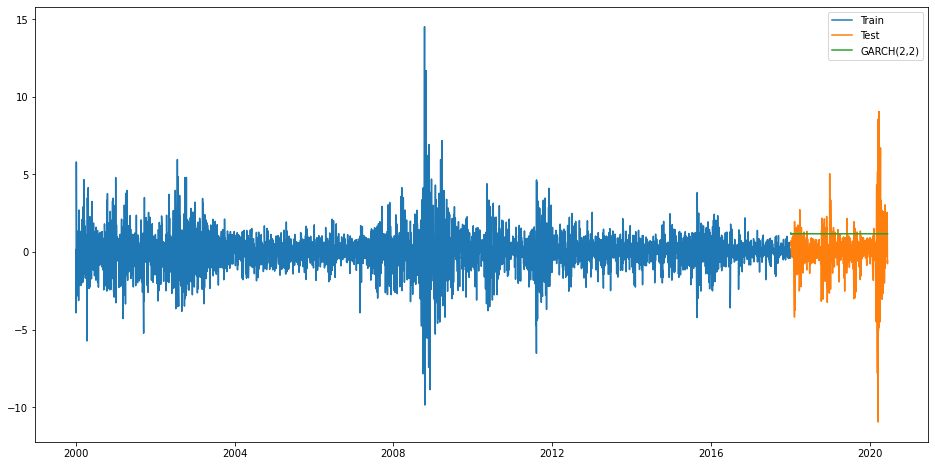

In [15]:
y_hat = test.copy()
predictions = results_garch.forecast(horizon=test.shape[0])
predicted_array = predictions.variance.values[-1:]
y_hat["GARCH(2,2)"] = np.sqrt(predicted_array.tolist()[0])
plt.figure(figsize=(16,8)) 
plt.plot( train['Pct'], label='Train') 
plt.plot(test['Pct'], label='Test') 
plt.plot(y_hat["GARCH(2,2)"], label="GARCH(2,2)") 
plt.legend(loc='best') 
plt.show()

#### The volatility is predicted in a much better way by GARCH as it takes both the previous error as well as the previous variance, hence is better for sudden shocks or bursts in data.